<a href="https://colab.research.google.com/github/luvbenz/2025-CV/blob/hw2/2-10.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Saving Fig0943(a)(dark_blobs_on_light_background).tif to Fig0943(a)(dark_blobs_on_light_background) (36).tif


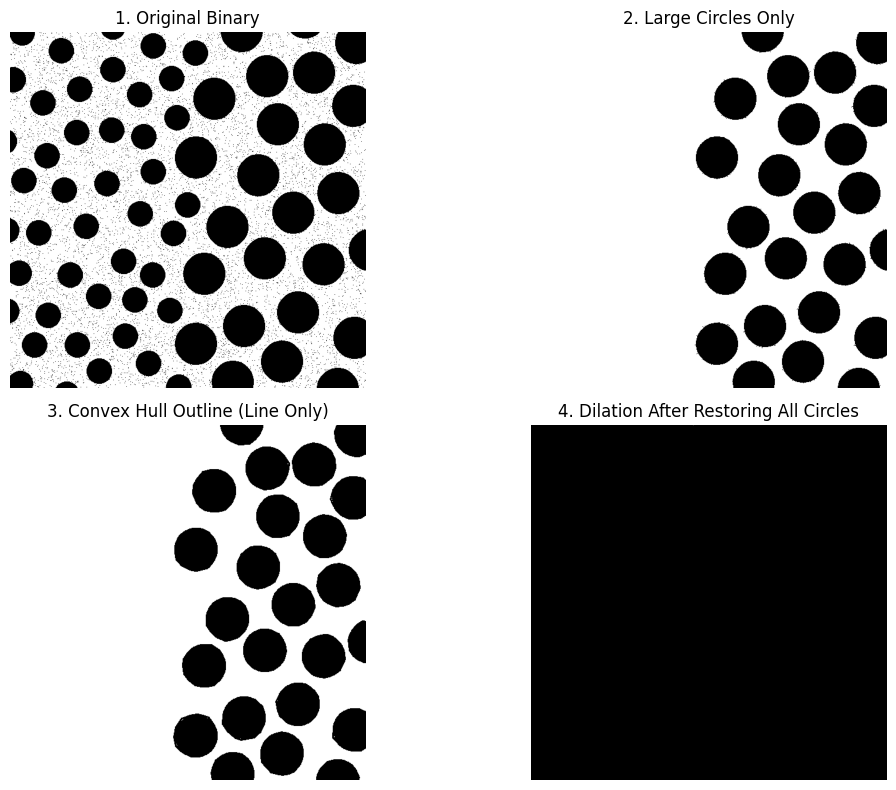

In [ ]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files

# 1. Upload image
uploaded = files.upload()
img_path = next(iter(uploaded))
img = cv.imread(img_path, cv.IMREAD_GRAYSCALE)

# 2. Binarization and inversion
_, binary = cv.threshold(img, 0, 255, cv.THRESH_BINARY + cv.THRESH_OTSU)
inv = cv.bitwise_not(binary)

# 3. Connected Components
num_labels, labels, stats, _ = cv.connectedComponentsWithStats(inv)

# 4. Keep large circles only
min_area = 1500
large_only = np.zeros_like(inv)
for i in range(1, num_labels):
    if stats[i, cv.CC_STAT_AREA] >= min_area:
        large_only[labels == i] = 255

# 5. Draw convex hull outline (as lines, not filled area)
contours, _ = cv.findContours(large_only, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
hull_outline = np.zeros_like(large_only)
for cnt in contours:
    if cv.contourArea(cnt) > 0:
        hull = cv.convexHull(cnt)
        cv.polylines(hull_outline, [hull], isClosed=True, color=255, thickness=2)

# 6. Restore all circles (include small)
full_circles = np.zeros_like(inv)
for i in range(1, num_labels):
    full_circles[labels == i] = 255

# 7. Apply dilation
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE, (25, 25))
dilated = cv.dilate(full_circles, kernel, iterations=1)

# 8. Visualization
titles = [
    '1. Original Binary',
    '2. Large Circles Only',
    '3. Convex Hull Outline (Line Only)',
    '4. Dilation After Restoring All Circles'
]
images = [
    binary,
    cv.bitwise_not(large_only),
    cv.bitwise_not(cv.bitwise_or(large_only, hull_outline)),
    cv.bitwise_not(dilated)
]

plt.figure(figsize=(12, 8))
for i in range(4):
    plt.subplot(2, 2, i + 1)
    plt.imshow(images[i], cmap='gray')
    plt.title(titles[i])
    plt.axis('off')
plt.tight_layout()
plt.show()
